In [64]:
from IPython.display import display, Image, Audio

from PIL import Image as PILImage

import imageio
import cv2  # We're using OpenCV to read video
import base64
import time
import openai
import os
import requests
import numpy as np

In [70]:
# video = cv2.VideoCapture("../data/stack_video.mov")
video = cv2.VideoCapture("../../data/robomimic/tool_hang/tool_hang.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

137 frames read.


In [71]:
# store frames with step number on them
video_writer = imageio.get_writer("../../data/robomimic/tool_hang/video_annotated.mp4", fps=100)
for i, base64_frame in enumerate(base64Frames):
    # Decode the base64 string
    img_data = base64.b64decode(base64_frame.encode("utf-8"))

    # Convert binary data to numpy array
    nparr = np.frombuffer(img_data, np.uint8)

    # Decode image
    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Put timestamp on the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f"frame number: {i}", (10, 30), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # Convert the frame back to an Image object
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # pil_img = PILImage.fromarray(frame)

    # Update the display handle
    # display_handle.update(pil_img)

    video_writer.append_data(frame)

video_writer.close()


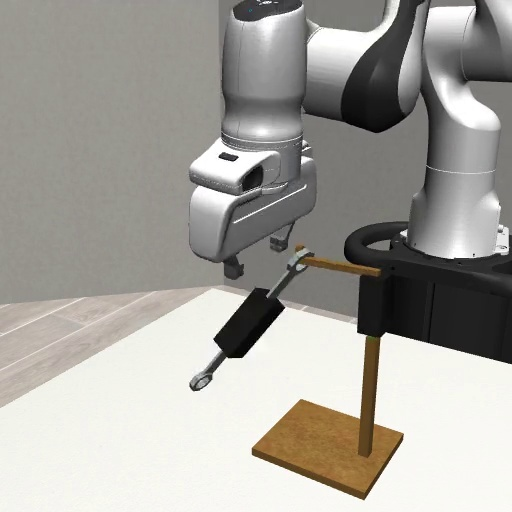

In [72]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

In [62]:
PROMPT = """Your task is to ingest the following data and break down what occurred during the robot episode into hierarchical granular subtasks. Each subtask should be a sequential step that occurred during the robot episode. The simulation step is associated with the frame I'm providing to you. You should identify the start step and end step of each subtask as its written in red on the video. Create as many granular subtasks as you see in the data.

Use chain of thought to break down the data into subtasks.

Report the list of subtasks as a dictionary with at the beginning of your response:
```subtask_decomposition = [
{1.1: {'start_step: 1, 'end_step': 10, subtask: '<low level primitive>'},
1.2: {'start_step: 11, 'end_step': 20, subtask: '<low level primitive>'},
2.1: {'start_step: 21, 'end_step': 30, subtask: '<low level primitive>'},
...
}]
```
Then explain your thoughts.
"""


PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [PROMPT,
            *map(lambda x: {"image": x, "resize": 480}, base64Frames[0::12]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": os.environ["OPENAI_API_KEY"],
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 1000,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

```
{1.1: {'start_step: 1, 'end_step': 12, subtask: 'Robot approaching the drawer'},
1.2: {'start_step: 13, 'end_step': 24, subtask: 'Robot gripping the drawer handle'},
2.1: {'start_step: 25, 'end_step': 36, subtask: 'Robot opening the drawer'},
2.2: {'start_step: 37, 'end_step': 48, subtask: 'Robot reaching into the drawer'},
3.1: {'start_step: 49, 'end_step': 60, subtask: 'Robot gripping an object inside the drawer'},
3.2: {'start_step: 61, 'end_step': 72, subtask: 'Robot extracting the object from the drawer'},
4.1: {'start_step: 73, 'end_step': 84, subtask: 'Robot maneuvering the object into position'},
4.2: {'start_step: 85, 'end_step': 96, subtask: 'Robot placing the object onto a specific location'},
5.1: {'start_step: 97, 'end_step': 108, subtask: 'Robot releasing the object'},
5.2: {'start_step: 109, 'end_step': 120, subtask: 'Robot retracting from the placed object'},
6.1: {'start_step: 121, 'end_step': 132, subtask: 'Robot returning to the initial rest position'}
}
```

Exp

In [63]:
result

<OpenAIObject chat.completion id=chatcmpl-8NloBLqMA2KyslwKusXkl5wucRpYH at 0x7fd3cada17c0> JSON: {
  "choices": [
    {
      "finish_details": {
        "stop": "<|fim_suffix|>",
        "type": "stop"
      },
      "index": 0,
      "message": {
        "content": "```\n{1.1: {'start_step: 1, 'end_step': 12, subtask: 'Robot approaching the drawer'},\n1.2: {'start_step: 13, 'end_step': 24, subtask: 'Robot gripping the drawer handle'},\n2.1: {'start_step: 25, 'end_step': 36, subtask: 'Robot opening the drawer'},\n2.2: {'start_step: 37, 'end_step': 48, subtask: 'Robot reaching into the drawer'},\n3.1: {'start_step: 49, 'end_step': 60, subtask: 'Robot gripping an object inside the drawer'},\n3.2: {'start_step: 61, 'end_step': 72, subtask: 'Robot extracting the object from the drawer'},\n4.1: {'start_step: 73, 'end_step': 84, subtask: 'Robot maneuvering the object into position'},\n4.2: {'start_step: 85, 'end_step': 96, subtask: 'Robot placing the object onto a specific location'},\n5.1: